In [1]:
import string
import html

import my_utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords as sw
from nltk import word_tokenize
from nltk import WordNetLemmatizer
from nltk import FreqDist

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from scipy.sparse import vstack

### Load Data

In [2]:
# Load data set as data frame
kindle_data = pd.read_csv('sampled_data.csv')

In [3]:
# Split dataset into pos & neg
def split_pos_neg(data_):
    neg = data_.loc[data_.overall == 'neg']
    pos = data_.loc[data_.overall == 'pos']
    return pos, neg

pos,neg = split_pos_neg(kindle_data)

### Enhanced Preprocessing

In [4]:
stopwords = sw.words('english')
stopwords = stopwords + ['not_' + w for w in stopwords]
lemmatizer = WordNetLemmatizer()

In [6]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [9]:
def preprocessing(line: str) -> str:
    line = html.unescape(str(line))
    line = str(line).replace("can't", "cann't") # unique case
    line = word_tokenize(line.lower())
    
    tokens = []
    negated = False
    for t in line:
        if t in ['not', "n't", 'no']:
            negated = not negated
        elif t in string.punctuation or not t.isalpha():
            negated = False
        else:
            tokens.append('not_' + t if negated else t) # cannot do that -> not_do
    
    tokens = [lemmatizer.lemmatize(t, 'v') for t in tokens if t not in stopwords]
        
    return ' '.join(tokens)

In [10]:
preprocessing("I can't beleive he wouldn't do that... He's really freaking me out.")

'not_beleive not_would really freak'

In [11]:
pos_data = []
n_pos = len(pos)
for i, p in enumerate(pos['reviewText']):
    pos_data.append(preprocessing(p))
    my_utils.print_progress(bar_length=50, decimals=0, iteration=i + 1, total=n_pos, prefix='Preprocessing pos data: ')

Preprocessing pos data:  |==================================================| 100% 


In [12]:
neg_data = []
n_neg = len(neg)
for i, n in enumerate(neg['reviewText']):
    neg_data.append(preprocessing(n))
    my_utils.print_progress(bar_length=50, decimals=0, iteration=i+1, total=n_neg, prefix='Preprocessing neg data: ')

Preprocessing neg data:  |==================================================| 100% 


In [13]:
data = pos_data + neg_data
labels = np.concatenate((pos['overall'].values,neg['overall'].values))

### Split data for testing

In [14]:
train_data, test_data, train_y, test_y = \
train_test_split(
    data, 
    labels, 
    test_size=0.2, 
    stratify=labels, 
    random_state=1234
)

In [15]:
tokens = [word for line in train_data \
               for word in word_tokenize(line)]

word_features = FreqDist(tokens)

### Find best \# features

Find best number of top words as features to use.

In [16]:
def train_with_n_topwords(n: int, tfidf=False) -> tuple:
    topwords = [fpair[0] for fpair in list(word_features.most_common(n))]
    
    if tfidf:
        vec = TfidfVectorizer()
    else:
        vec = CountVectorizer()
        
    vec.fit(topwords)
    
    # Generate feature vectors
    train_X = vec.transform(train_data)
    test_X  = vec.transform(test_data)
    
    # NB
    mnb_model = MultinomialNB()
    mnb_model.fit(train_X, train_y)
    
    # Test predict
    pred = mnb_model.predict(test_X)
    
    return accuracy_score(pred, test_y), mnb_model

In [17]:
train_with_n_topwords(5000, tfidf=True)

(0.82841379310344831,
 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))

In [18]:
possible_n = [5000 * i for i in range(1, 20)]

cnt_accuracies = []
tfidf_accuracies = []
for i, n in enumerate(possible_n):
    cnt_accuracies.append(train_with_n_topwords(n)[0])
    my_utils.print_progress(bar_length=50, decimals=0, iteration=2 * i + 1, total=2*len(possible_n), prefix='Train and verify:')
    
    tfidf_accuracies.append(train_with_n_topwords(n, tfidf=True)[0])
    my_utils.print_progress(bar_length=50, decimals=0, iteration=2 * i + 2, total=2*len(possible_n), prefix='Train and verify:')

Train and verify: |==================================================| 100% 


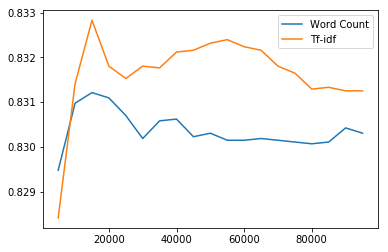

In [19]:
%matplotlib inline
plt.plot(possible_n, cnt_accuracies, label='Word Count')
plt.plot(possible_n, tfidf_accuracies, label='Tf-idf')
plt.legend()

In [20]:
train_with_n_topwords(15000, tfidf=True)

(0.83282758620689656,
 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))

In [21]:
# Train actuall model (tfidf + 15000 features)
topwords = [fpair[0] for fpair in list(word_features.most_common(15000))]

tfidf_vec = TfidfVectorizer()
tfidf_vec.fit(topwords)

train_X = tfidf_vec.transform(train_data)
test_X  = tfidf_vec.transform(test_data)

X = vstack([train_X, test_X])
y = np.append(train_y, test_y)

best_model = MultinomialNB()
best_model.fit(train_X, train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Save model

In [22]:
import pickle
import os

if not os.path.exists('model'):
    os.makedirs('model')

# Save vectorizer
with open('model/tf_vec.pkl', 'wb') as pkl_file:
    pickle.dump(tfidf_vec, pkl_file)

# Save Model
with open('model/mnb_model.pkl', 'wb') as pkl_file:
    pickle.dump(best_model, pkl_file)